In [1]:
from google.colab import drive
drive.mount('/content/drive')
sent_path = "/content/drive/My Drive/Main model working folder/sentiment_data.csv"
sp500_path = "/content/drive/My Drive/Main model working folder/GSPCIndicators2.csv"
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [2]:
sentiment = pd.read_csv(sent_path, parse_dates=["Date"])
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)
sentiment['Date'] = pd.to_datetime(sentiment['Date']).dt.tz_localize(None).dt.normalize()
sentiment_df = sentiment[['Date','sentiment_encoded']]

sentiment_df = sentiment.groupby("Date")[["sentiment_encoded"]].mean().reset_index()
sentiment_df = sentiment_df.sort_values("Date")
start_date = sentiment_df["Date"].min()
end_date = sentiment_df["Date"].max()

In [3]:
sp500 = pd.read_csv(sp500_path, parse_dates=["Date"])
sp500_df = sp500[(sp500['Date'] >= start_date) & (sp500['Date'] <= end_date)]
sp500_df = sp500_df[['Date','GSPC.Close','10DaysPercent']]
sp500_df.dropna()
sp500_df.shape

(2739, 3)

In [4]:
merged_df = pd.merge(sentiment_df, sp500, on="Date", how="left")
merged_df = merged_df.sort_values("Date")
merged_df = merged_df.dropna()

In [5]:
merged_df["target_return"] = merged_df["GSPC.Close"].pct_change().shift(-1)

merged_df["target_direction"] = (merged_df["target_return"] > 0).astype(int)

model_df = merged_df.dropna(subset=["target_return", "sentiment_encoded"])
model_df.shape

(2657, 33)

In [6]:
features = model_df[["sentiment_encoded"]]
X = features
y_reg = model_df["target_return"]
y_class = model_df["target_direction"]

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, shuffle=False)
_, _, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, shuffle=False)

In [7]:
reg_model = RandomForestRegressor(random_state=42)
reg_model.fit(X_train, y_train_reg)
y_pred_reg = reg_model.predict(X_test)

print("\n Regression Metrics (Predicting Return):")
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")

clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train_class)
y_pred_class = clf_model.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test_class, y_pred_class))


 Regression Metrics (Predicting Return):
RMSE: 0.016435
R² Score: -0.0652

 Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.36      0.40       238
           1       0.55      0.64      0.60       294

    accuracy                           0.52       532
   macro avg       0.50      0.50      0.50       532
weighted avg       0.51      0.52      0.51       532



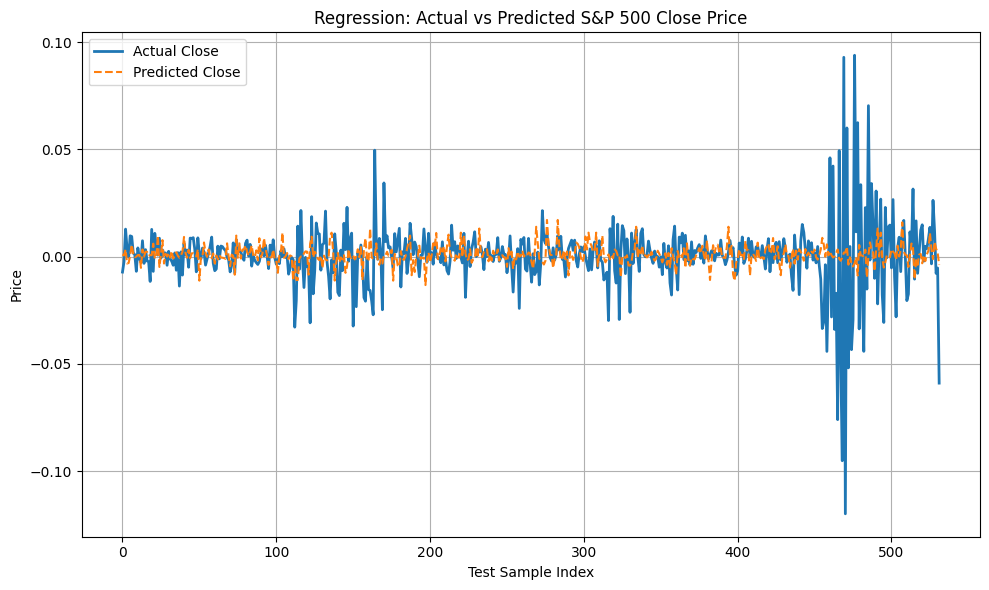

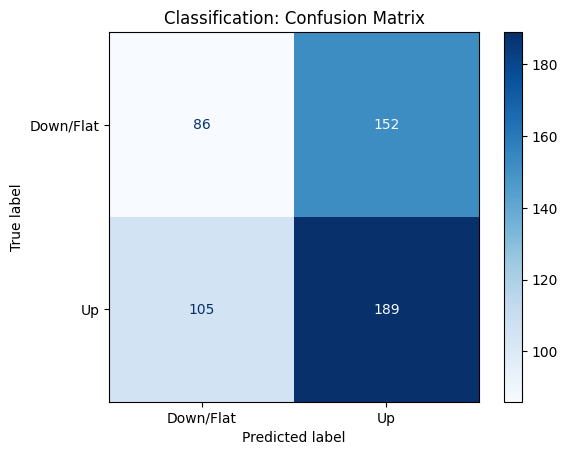

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg.values, label="Actual Close", linewidth=2)
plt.plot(y_pred_reg, label="Predicted Close", linestyle='--')
plt.title("Regression: Actual vs Predicted S&P 500 Close Price")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down/Flat", "Up"])
disp.plot(cmap="Blues")
plt.title("Classification: Confusion Matrix")
plt.show()

